# Multinomial Logistic Regression for Sea Ice Age

Tschudi, M., C. Fowler, J. Maslanik, J. S. Stewart, and W. Meier. 2016. EASE-Grid Sea Ice Age, Version 3. [Indicate subset used]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/PFSVFZA9Y85G. [06/14/2018].

In [1]:
%matplotlib inline
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
matplotlib.rcParams['font.size'] = 16

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt

# Helper functions pre-written for this problem
from IceAgeUtilities import *

# MUQ Includes
import pymuqModeling as mm
import pymuqApproximation as ma
import pymuqUtilities as mu
import pymuqSamplingAlgorithms as ms

## Read Data

In [2]:
thinBy = 100
numClasses = 3 

timeRaw, latRaw, lonRaw, ages = ReadIceAges(thinBy, numClasses)

# Scale the independent variables to have domain [0,1]
minTime, maxTime = np.min(timeRaw), np.max(timeRaw)
minLat, maxLat = np.min(latRaw), np.max(latRaw)
minLon, maxLon = np.min(lonRaw), np.max(lonRaw)

time = (timeRaw-minTime)/(maxTime-minTime)
lat = (latRaw-minLat)/(maxLat-minLat)
lon = 0.5*np.cos( 2.0*np.pi*(lonRaw-minLon)/(maxLon - minLon) )+0.5

print('Using a total of %d age observations'%lat.shape[0])


Using a total of 30464 age observations


## Plot data

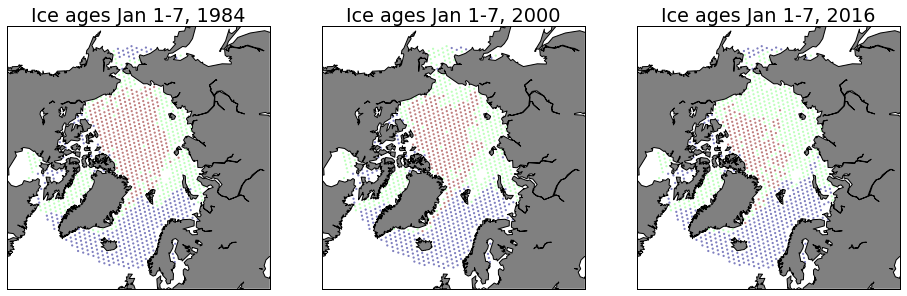

In [3]:
fig = plt.figure()
ax = fig.add_subplot(131)
PlotAgeScatter(1984, timeRaw, latRaw, lonRaw, ages)

ax = fig.add_subplot(132)
PlotAgeScatter(2000, timeRaw, latRaw, lonRaw, ages)

ax = fig.add_subplot(133)
PlotAgeScatter(2016, timeRaw, latRaw, lonRaw, ages)

## Set up Multi-Logistic Regression

In [4]:
polyOrder = 3
numObs = len(ages)

numIndp = 3 # number of independent variables [time, lat, lon]

set  = mu.MultiIndexFactory.CreateTotalOrder(numIndp,polyOrder)
poly = ma.ProbabilistHermite()
partialV    = ma.BasisExpansion([poly]*numIndp, set).BuildVandermonde(np.hstack([time[:,None], lat[:,None], lon[:,None]]).T )

termsPerClass = partialV.shape[1]

V = np.zeros((numClasses*numObs, numClasses*termsPerClass))
for c in range(numClasses):
    V[c::numClasses, c*termsPerClass:(c+1)*termsPerClass] = partialV
    


In [5]:
forwardModel = mm.DenseLinearOperator(V)
print('Number of model parameters = ', forwardModel.inputSizes[0])

likelihood = mm.MultiLogisticLikelihood(numClasses,ages)

prior = mm.Gaussian(np.zeros(V.shape[1]), np.eye(V.shape[1]))

graph = mm.WorkGraph()

graph.AddNode(mm.IdentityOperator(V.shape[1]),"Parameters")
graph.AddNode(prior.AsDensity(),"Prior")
graph.AddNode(forwardModel, "ForwardModel")
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(mm.DensityProduct(2),"Posterior")

graph.AddEdge("Parameters",0, "Prior",0)
graph.AddEdge("Parameters",0,"ForwardModel",0)
graph.AddEdge("ForwardModel",0, "Likelihood",0)
graph.AddEdge("Likelihood",0, "Posterior",1)
graph.AddEdge("Prior",0, "Posterior",0)

graph.Visualize("PosteriorGraph.png")

Number of model parameters =  60


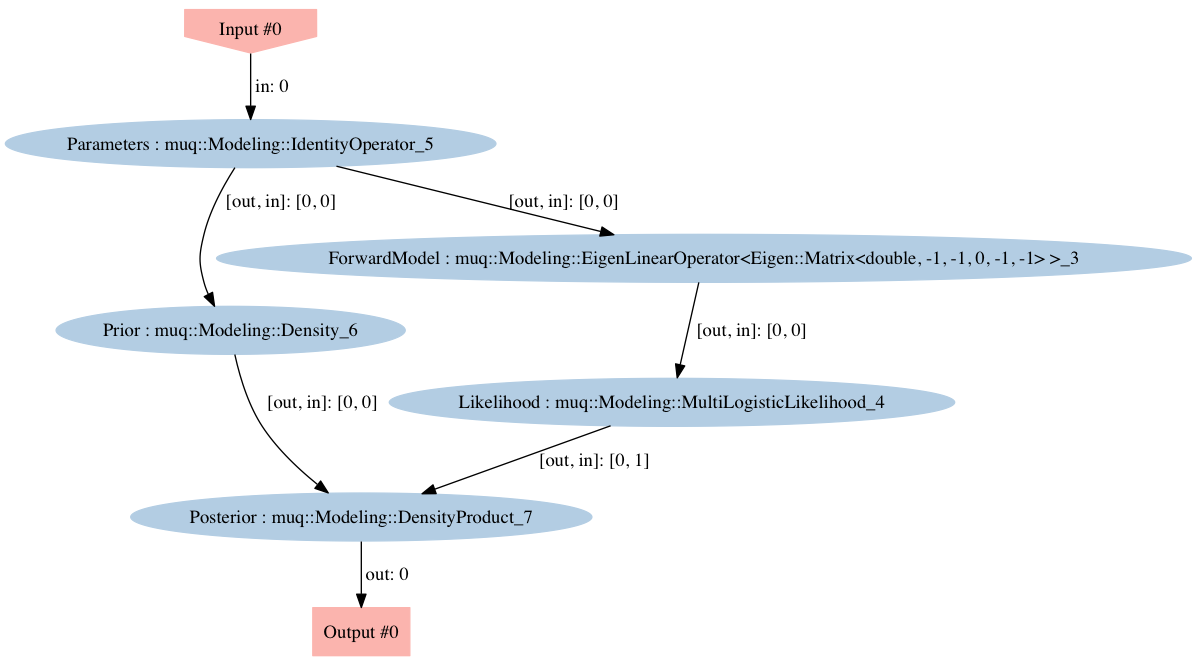

In [6]:
Image(filename='PosteriorGraph.png') 

## Explore the posterior with MCMC

In [7]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [8]:
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1e-3
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 1e-2

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 50000
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [9]:
startPt = np.zeros(V.shape[1])
samps = mcmc.Run(startPt)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 28%
  20% Complete
    Block 0:
      Acceptance Rate = 34%
  30% Complete
    Block 0:
      Acceptance Rate = 38%
  40% Complete
    Block 0:
      Acceptance Rate = 41%
  50% Complete
    Block 0:
      Acceptance Rate = 43%
  60% Complete
    Block 0:
      Acceptance Rate = 44%
  70% Complete
    Block 0:
      Acceptance Rate = 46%
  80% Complete
    Block 0:
      Acceptance Rate = 47%
  90% Complete
    Block 0:
      Acceptance Rate = 48%
  100% Complete
    Block 0:
      Acceptance Rate = 49%
Completed in 607.742 seconds.


Generated a chain of length 50001


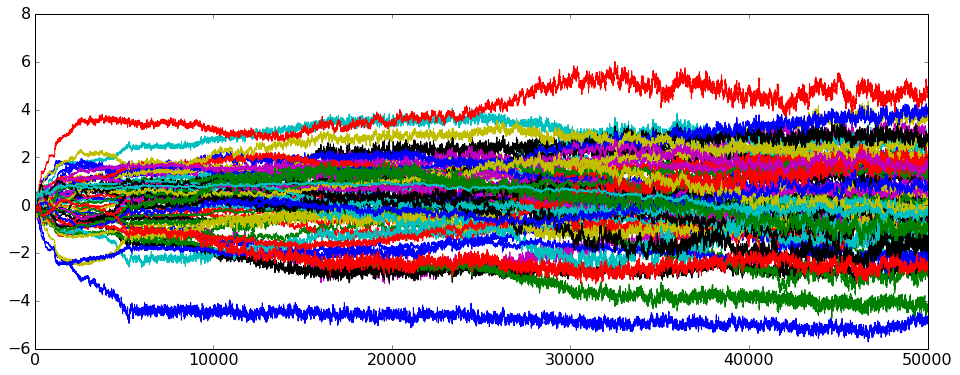

In [10]:
print('Generated a chain of length %d'%samps.size())
sampMat = samps.AsMatrix()

plt.plot(sampMat.T)
plt.show()

## Sample the Posterior Predictive Distribution

In [11]:
# Draw a single random posterior-predictive sample
burnIn = 20000
mcmcInd = np.random.randint(burnIn,options['NumSamples'],1)[0]

logProbs = forwardModel.Evaluate([sampMat[:,mcmcInd]])[0].reshape(-1,numClasses).T
NormalizeProbs(logProbs)
    
ageSamp = np.zeros(numObs)
for i in range(numObs):
    ageSamp[i] = np.random.choice(list(range(numClasses)), 1, p=np.exp(logProbs[:,i]))

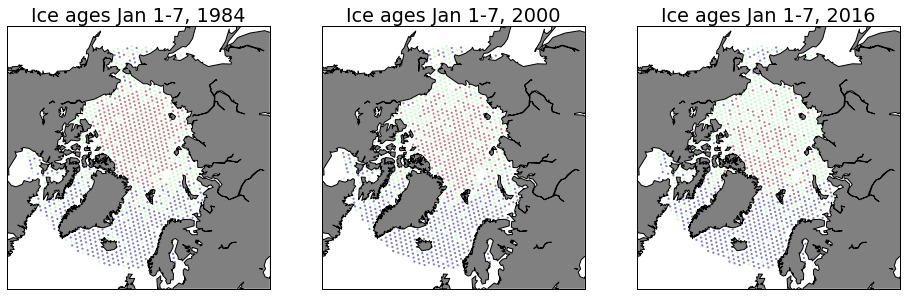

In [12]:
fig = plt.figure()
ax = fig.add_subplot(131)
PlotAgeScatter(1984, timeRaw, latRaw, lonRaw, ageSamp)

ax = fig.add_subplot(132)
PlotAgeScatter(2000, timeRaw, latRaw, lonRaw, ageSamp)

ax = fig.add_subplot(133)
PlotAgeScatter(2016, timeRaw, latRaw, lonRaw, ageSamp)

## Study the Probability Over Time

<img src="PointOfInterest.png" alt="POI" width="600px"/>


In [13]:
newTimeRaw = np.array(range(1984,2041))
newLatRaw = 76 * np.ones(newTimeRaw.shape[0])
newLonRaw = 28 * np.ones(newTimeRaw.shape[0])

# Scale the independent variables in the same way we did above
newTime = (newTimeRaw - minTime)/(maxTime-minTime)
newLat = (newLatRaw - minLat)/(maxLat-minLat)
newLon = 0.5 * np.cos( 2.0*np.pi * (newLonRaw-minLon)/(maxLon-minLon))+0.5

# Construct the Vandermonde matrix for the new points
partialV    = ma.BasisExpansion([poly]*numIndp, set).BuildVandermonde(np.hstack([newTime[:,None], newLat[:,None], newLon[:,None]]).T )
V = np.zeros((numClasses*newTimeRaw.shape[0], numClasses*termsPerClass))
for c in range(numClasses):
    V[c::numClasses, c*termsPerClass:(c+1)*termsPerClass] = partialV
    

# Compute the marginal log-probabilities (integrating over model parameters)
probs = np.zeros((numClasses, newTimeRaw.shape[0], options['NumSamples']-burnIn ))
for i in range(burnIn,options['NumSamples']):
    currProb = np.exp(np.dot(V, sampMat[:,i]).reshape(-1,numClasses).T)
    currProb /= np.sum(currProb,axis=0)
    probs[:,:,i-burnIn] = currProb
    


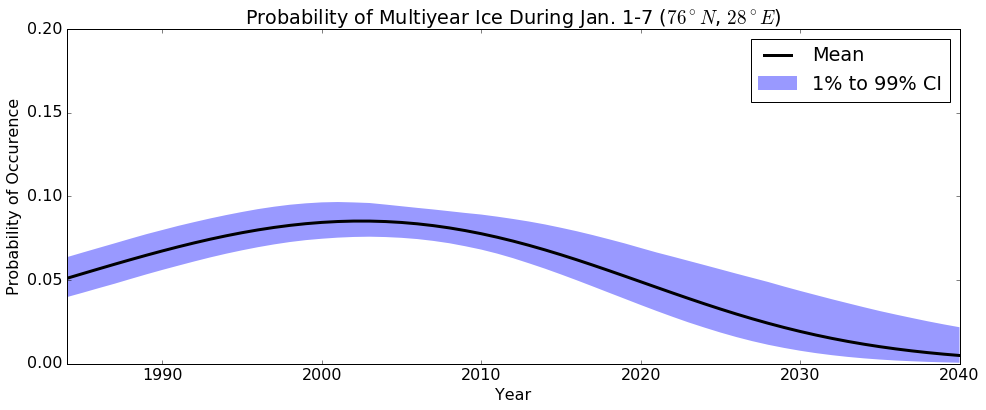

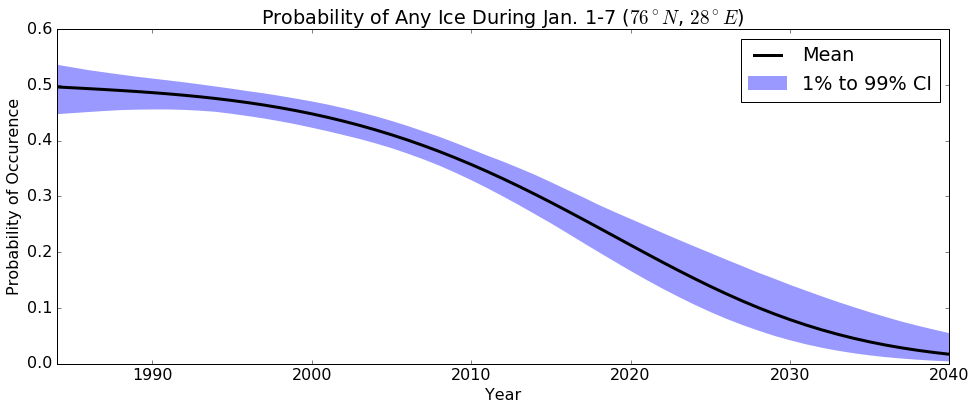

In [14]:
## Plot the probability of multiyear ice being present
plt.fill_between(newTimeRaw,np.percentile(probs[2,:,:],1,axis=1),np.percentile(probs[2,:,:],99,axis=1), alpha=0.4, edgecolor='None', label='1% to 99% CI')
plt.plot(newTimeRaw, np.mean(probs[2,:,:],axis=1), 'k', linewidth=3, label='Mean')

plt.title('Probability of Multiyear Ice During Jan. 1-7 ($%0.0f^\circ N$, $%0.0f^\circ E$)'%(newLatRaw[0], newLonRaw[0]))
plt.xlabel('Year')
plt.ylabel('Probability of Occurence')
plt.ylim([0,0.2])
plt.xlim([1984,2040])
plt.legend()

## Plot the probability of any ice being present
plt.figure()
plt.fill_between(newTimeRaw,np.percentile(1-probs[0,:,:],1,axis=1),np.percentile(1-probs[0,:,:],99,axis=1), alpha=0.4, edgecolor='None', label='1% to 99% CI') 
plt.plot(newTimeRaw, np.mean(1.0-probs[0,:,:],axis=1), 'k', linewidth=3, label='Mean')

plt.title('Probability of Any Ice During Jan. 1-7 ($%0.0f^\circ N$, $%0.0f^\circ E$)'%(newLatRaw[0], newLonRaw[0]))
plt.xlabel('Year')
plt.ylabel('Probability of Occurence')
plt.ylim([0,0.6])
plt.xlim([1984,2040])
plt.legend()

plt.show()